# Pengembangan Sistem Pencarian Resep Masakan Indonesia Menggunakan Metode BM25 dan FastText

In [1]:
import pandas as pd
import numpy as np
import collections
import gensim 
from gensim.models import word2vec, phrases
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric,\
                    strip_non_alphanum, strip_multiple_whitespaces, strip_short
from textblob import TextBlob, Word

import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [2]:
# Membaca dan menghitung jumlah file serta folder yang ada dalam direktori saat ini
import os
fc=0
for el in os.listdir("."):
    fc+=1
    print(" - ",el)
print("found",fc,"files!")

 -  .ipynb_checkpoints
 -  app.py
 -  data_indo
 -  env
 -  laporan akhir_stki.docx
 -  model-ayam.ipynb
 -  model-kambing.ipynb
 -  model-telur.ipynb
 -  model.ipynb
 -  models
 -  processed
 -  requirements.txt
found 12 files!


In [3]:
files = [
    'data_indo/dataset-ayam.csv',
    'data_indo/dataset-kambing.csv',
    'data_indo/dataset-telur.csv',
    'data_indo/dataset-udang.csv'
]

In [4]:
# Membaca file CSV dan membuat salinan dari data
raw = pd.read_csv(r"data_indo/dataset-udang.csv")
df = raw.copy()
df.head() # menampilkan

,Title,Ingredients,Steps,Loves,URL
0,Lumpia udang kulit tahu ala fe',50 gram ayam potong kotak kecil--200 gram udan...,Campur ayam & udang dengan semua bumbu & daun ...,4,/id/resep/4448366-lumpia-udang-kulit-tahu-ala-fe
1,Bakso Ayam Udang Keto,400 gr ayam giling--250 gr udang kupas--3 telu...,"Campur semua bahan dalam food processor, kecua...",2,/id/resep/4474544-bakso-ayam-udang-keto
2,Udang ala pop corn,1/4 kg udang basah ukuran sedang--1 bungkus ko...,Buang kepala dan cangkang udang.--Cuci bersih ...,2,/id/resep/4418156-udang-ala-pop-corn
3,Bakwan Udang Sederhana,1/2 kg Tepung terigu (sudah di ayak)--1/2 Udan...,"Haluskan bawang putih, garam, picin dan merica...",0,/id/resep/4475500-bakwan-udang-sederhana
4,Udang Goreng Tepung Mayonaise,300 gr udang (buang kepalanya)--Jeruk nipis--T...,"Cuci bersih udang, tambahkan jeruk nipis supay...",6,/id/resep/4474156-udang-goreng-tepung-mayonaise


In [5]:
# Menghapus kolom 'URL' 
columns_to_drop = ['URL']
df_indoRecipes = df.drop(columns = columns_to_drop).dropna()

df_indoRecipes.head() # menampilkan 

,Title,Ingredients,Steps,Loves
0,Lumpia udang kulit tahu ala fe',50 gram ayam potong kotak kecil--200 gram udan...,Campur ayam & udang dengan semua bumbu & daun ...,4
1,Bakso Ayam Udang Keto,400 gr ayam giling--250 gr udang kupas--3 telu...,"Campur semua bahan dalam food processor, kecua...",2
2,Udang ala pop corn,1/4 kg udang basah ukuran sedang--1 bungkus ko...,Buang kepala dan cangkang udang.--Cuci bersih ...,2
3,Bakwan Udang Sederhana,1/2 kg Tepung terigu (sudah di ayak)--1/2 Udan...,"Haluskan bawang putih, garam, picin dan merica...",0
4,Udang Goreng Tepung Mayonaise,300 gr udang (buang kepalanya)--Jeruk nipis--T...,"Cuci bersih udang, tambahkan jeruk nipis supay...",6


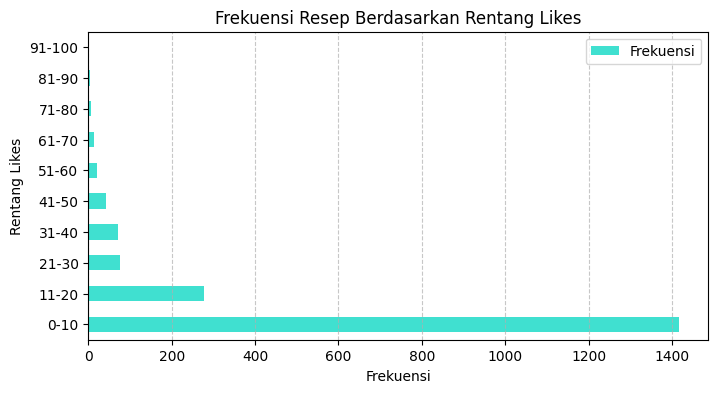

In [6]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Membagi nilai kolom Loves ke dalam kategori yang lebih kecil berdasarkan rentang angka
# list yang berisi label untuk setiap rentang yang ada pada bins
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# pd.cut untuk mengkategorikan kolom Loves ke dalam rentang-rentang yang telah didefinisikan pada variabel bins
df_indoRecipes['Loves_bin'] = pd.cut(df_indoRecipes['Loves'], bins=bins, labels=labels, right=True)

# Menghitung frekuensi masing-masing kategori pada kolom Loves_bin dan mengurutkannya berdasarkan label bin
counts = df_indoRecipes['Loves_bin'].value_counts().sort_index()

# Membuat DataFrame untuk Visualisasi
mc = pd.DataFrame(counts).reset_index()
mc.columns = ['Rentang Likes', 'Frekuensi']

# Memvisualisasikan Data dengan Grafik Batang Horizontal
mc.plot(kind='barh', x='Rentang Likes', color='turquoise', figsize=(8,4))
plt.xlabel('Frekuensi')
plt.ylabel('Rentang Likes')
plt.title('Frekuensi Resep Berdasarkan Rentang Likes')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

                            File  Row Count
0     data_indo/dataset-ayam.csv       1916
1  data_indo/dataset-kambing.csv       1896
2    data_indo/dataset-telur.csv       1974
3    data_indo/dataset-udang.csv       1994


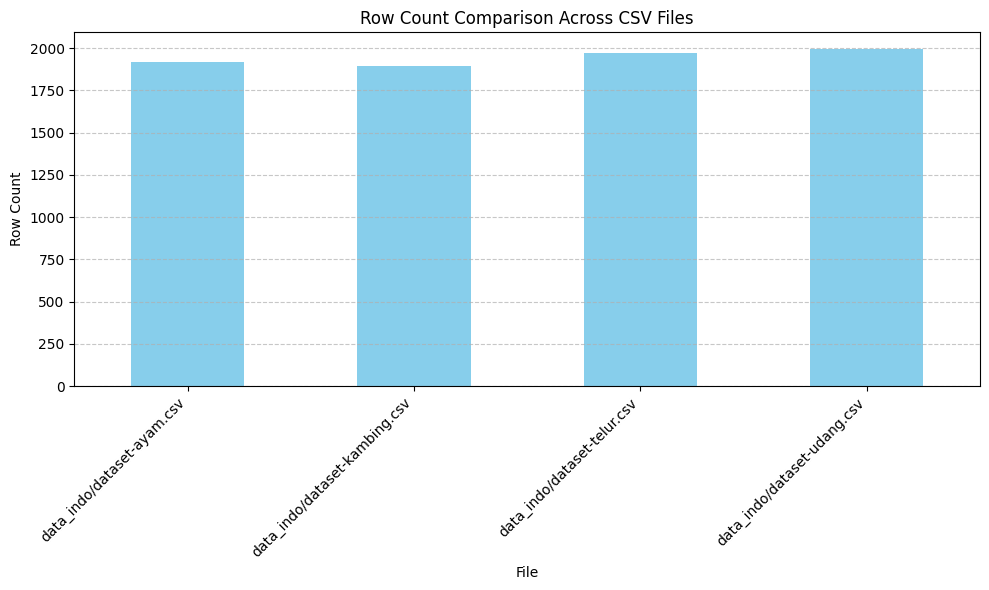

In [7]:
# Membuat dictionary kosong yang nantinya akan menyimpan nama file CSV sebagai kunci
row_counts_dict = {}

# Melakukan iterasi untuk setiap file yang ada dalam list files
for file in files:
    try:
        # Membaca file CSV
        df = pd.read_csv(file)
        
        # Menghitung jumlah baris dalam DataFrame
        row_count = len(df)
        
        # Menyimpan jumlah baris ke dalam dictionary
        row_counts_dict[file] = row_count
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Mengonversi dictionary ke DataFrame
row_counts_df = pd.DataFrame(list(row_counts_dict.items()), columns=['File', 'Row Count'])

# Menampilkan DataFrame
print(row_counts_df)

# Membuat grafik berdasarkan data jumlah baris yang ada di DataFrame
fig, ax = plt.subplots(figsize=(10, 6))

# Menggambar grafik batang (bar chart) dengan nama file di sumbu x dan jumlah baris di sumbu y
row_counts_df.plot(kind='bar', x='File', y='Row Count', ax=ax, color='skyblue', legend=False)
plt.title('Row Count Comparison Across CSV Files')
plt.xlabel('File')
plt.ylabel('Row Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menyesuaikan tata letak untuk memuat label
plt.tight_layout()

# Menampilkan plot
plt.show()

In [8]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
# Membuat Mask Boolean
mask = df_indoRecipes['Ingredients'].apply(isEnglish)
df_indoRecipes = df_indoRecipes[mask].dropna() # Menerapkan Mask dan Menghapus Nilai Kosong (NaN)

# Menampilkan Bentuk Data
print("Dimensi data resep:",df_indoRecipes.shape)

Dimensi data resep: (1847, 5)


In [9]:
# Mengubah Semua Teks Menjadi Huruf Kecil
df_indoRecipes['Ingredients'] = df_indoRecipes['Ingredients'].apply(lambda x: x.lower())

# Inisialisasi Daftar Bahan
total_ingredients = []
all_receipes_ingredients =  []
# Memproses Setiap Resep
for i in range(len(df_indoRecipes)):
    all_ingredients = list()
    # Memisahkan setiap resep menjadi bahan-bahan yang terpisah
    try:
        ingred = df_indoRecipes.loc[i, "Ingredients"][1:-1]
    except:
        continue;

    # Membersihkan dan Memisahkan Setiap Bahan
    for ing in (ingred.split(',')):
        ing = remove_stopwords(ing) # Menghapus stopwords
        ing = strip_numeric(ing) # Menghapus angka
        ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|tast|sprig|inch|purpose|flmy|taste|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground|tablespoon|teaspoon|cup','',ing).strip()
        ing = strip_short(ing,2)
        ing = strip_multiple_whitespaces(ing) # Menghapus spasi ganda
        ing = strip_punctuation(ing)
        ing = strip_non_alphanum(ing)
        
        if len(ing)>0:
            all_ingredients.append(ing)
            total_ingredients.append(ing)
    all_receipes_ingredients.append(all_ingredients)
counts_ingr = collections.Counter(total_ingredients) # Menghitung jumlah kemunculan setiap bahan di seluruh resep
all_receipes_ingredients.append(all_ingredients)

---- Bahan Paling Umum ----
[('gula', 60), ('garam', 52), ('gr udang', 45), ('ap rasa ', 33), ('ap ', 29), ('udang', 27), ('iris  siung bawang putih', 25), ('ang', 23), ('ikit air ', 22), ('kupas', 15), ('ri', 13), ('garam ', 11), ('lada', 11), ('iris tipis  siung bawang putih', 10), ('bersihkan', 10), ('buang kepala', 10), ('merica', 10), ('gram udang', 9), ('gula ', 8), ('ap', 8), ('cuci', 8), ('merica ', 7), ('ap rasa', 7), ('gula pasir', 7), ('iris  siung bawang merah', 6)]


---- Bahan Paling Jarang ----
[('dang tempe pete bawang merah bawang putih cabai merah tomat secukupnya gula dan garam ', 1), ('cuci tiriskn  bgks tepung serbaguna  sdm terigu minyak untuk menggoreng secukupnya air ', 1), ('ri garam gula merica ', 1), ('ap rasa garam dan gula secukup nya minyak goreng ', 1), ('gram udang  buah jagung  buah bawang daun  siung bawang putih  siung bawang merah tepung terigu kunyit air sesuai selera gula', 1), ('ap minyak untuk menggoreng ', 1), ('gr udang kupas  bh anak jagung po

<Axes: ylabel='kata'>

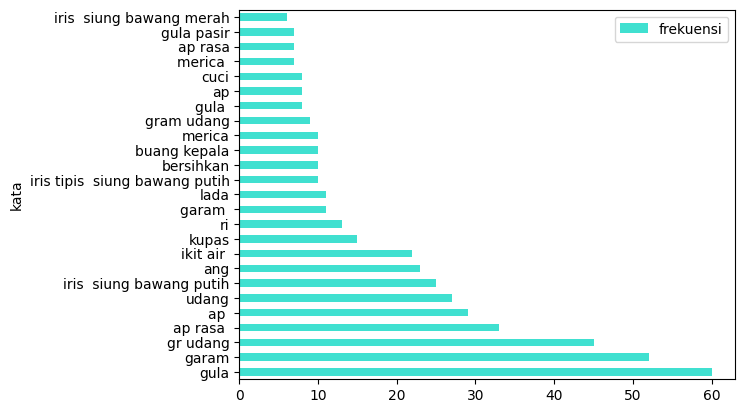

In [10]:
# Mencari bahan yang paling umum digunakan di semua resep
print ("---- Bahan Paling Umum ----")
print (counts_ingr.most_common(25))

print ("\n")
# Mencari bahan yang paling jarang digunakan di semua resep
print ("---- Bahan Paling Jarang ----")
print (counts_ingr.most_common()[-10:])
print("type counts ingr",type(counts_ingr))

most_common = counts_ingr.most_common(25)
mc = pd.DataFrame(most_common, columns=['kata', 'frekuensi'])

mc.plot(kind='barh', x='kata', align='center', color='turquoise')

In [11]:
# Pemrosesan dan pembersihan langkah-langkah resep (Steps)
# Mengonversi ke huruf kecil
df_indoRecipes['Steps'] = df_indoRecipes['Steps'].apply(lambda x: x.lower())

all_instructions =  []

for i in range(len(df_indoRecipes)):
    try:
        instrs = df_indoRecipes.loc[i, "Ingredients"][1:-1]
    except:
        continue;      
    for instr in (instrs.split('.')):
        instr = remove_stopwords(instr)
        instr = strip_numeric(instr)
        instr = strip_short(instr,2)
        instr = strip_multiple_whitespaces(instr)
        instr = strip_punctuation(instr)
        instr = strip_non_alphanum(instr)
        if len(instr)>0:
            all_instructions.append(instr)

# Menampilkan panjang list all_instructions
print("len",len(all_instructions))

# Memformat kolom dengan cara yang bisa diterima oleh gensim
all_instructions_splitted = [sentx.split() for sentx in all_instructions]

# Menyimpan dataframe yang sudah diproses
df_indoRecipes.to_pickle("processed/df_indoRecipesUdang.pkl")

len 1807


In [12]:
# Menambahkan Bahan Bersih ke DataFrame
df_indoRecipes['clean_ingredients'] = pd.Series(all_receipes_ingredients)
# Menghapus Baris yang Mengandung Nilai Kosong (NaN)
df_indoRecipes = df_indoRecipes.dropna()
# Menghitung Jumlah Bahan untuk Setiap Resep 
df_indoRecipes['ingredient_count'] =  df_indoRecipes.apply(lambda row: len(row['clean_ingredients']), axis = 1)
# Membersihkan Instruksi Resep untuk pelatihan recipe embeddings.
df_indoRecipes['clean_instructions'] = df_indoRecipes['Steps'].apply(lambda x: x.lower())
# Menampilkan Kolom clean_instructions
df_indoRecipes['clean_instructions']

0       campur ayam & udang dengan semua bumbu & daun ...
1       campur semua bahan dalam food processor, kecua...
2       buang kepala dan cangkang udang.--cuci bersih ...
4       cuci bersih udang, tambahkan jeruk nipis supay...
7       cuci udang bersih, lumuri dengan jeruk nipis--...
                              ...                        
1699    kupas udang, sisihkan kepala nya. kepala nya d...
1700    bersihkan udang, belah bagian atasnya, lumuri ...
1701    siap kan semua bahan, potong dan cuci bersih. ...
1702    panaskan wajan, tuang minyak tunggu hingga pan...
1703    panaskan minyak setelah panas masukan bumbu ha...
Name: clean_instructions, Length: 1568, dtype: object

In [13]:
df_indoRecipes.to_pickle("processed/df_indoRecipesUdang.pkl")

In [14]:
# Fungsi untuk memproses kolom 'recipe' ke format list-of-lists.
import re
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, strip_non_alphanum, strip_multiple_whitespaces, strip_short

def process_recipe(recipe):
    recipeProcessed = []
    for ing in (recipe.split(',')):
        ing = remove_stopwords(ing)
        ing = strip_numeric(ing)
        ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|tast|sprig|inch|purpose|flmy|taste|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground|tablespoon|teaspoon|recipe|cup','',ing).strip()
        ing = strip_short(ing,2)
        ing = strip_multiple_whitespaces(ing)
        ing = strip_punctuation(ing)
        ing = strip_non_alphanum(ing)
        if ing: # Jika setelah diproses masih ada bahan yang tersisa
            recipeProcessed.append(ing) # Menambahkan bahan yang sudah dibersihkan ke dalam list
    return [oneInstr.split() for oneInstr in recipeProcessed] # Memisahkan setiap instruksi menjadi kata-kata (list)

process_recipe(df_indoRecipes['clean_instructions'][11])

[['bersihkan', 'udang', 'iris', 'bawang', 'merah'],
 ['bawang',
  'putih',
  'dan',
  'bawang',
  'bombai',
  'menjadi',
  'bagian',
  'yang',
  'kecil',
  'dan',
  'tipis',
  'siapkan',
  'wajan',
  'teflon'],
 ['nyalakan', 'api', 'kecil'],
 ['kemudian',
  'masukan',
  'mentega',
  'hingga',
  'leleh',
  'dan',
  'panas',
  'tumis',
  'bawang',
  'merah',
  'dan',
  'bawang',
  'putih',
  'sebentar',
  'saja',
  'sekitar',
  'menit',
  'lalu',
  'masukan',
  'bawang',
  'bombai',
  'tumis',
  'lagi',
  'hingga',
  'harum',
  'masukkan',
  'udang'],
 ['garam'],
 ['saus', 'tiram'],
 ['as',
  'dan',
  'saus',
  'tomat',
  'aduk',
  'hingga',
  'rata',
  'jika',
  'sudah',
  'matang'],
 ['angkat', 'dan', 'sajikan']]

In [15]:
# Menambahkan instruksi yang telah dibersihkan
df_indoRecipes['clean_instructions'] = df_indoRecipes['clean_instructions'].apply(lambda x:process_recipe(x))
print(df_indoRecipes['clean_instructions'][1])

[['campur', 'semua', 'bahan', 'dalam', 'food', 'processor'], ['kecuali', 'daun', 'bawang', 'dan', 'minyak', 'goreng', 'tuang', 'dalam', 'baskom', 'lalu', 'taburi', 'daun', 'bawang', 'dan', 'minyak', 'goreng'], ['ang', 'bulatkan', 'adonan', 'dengan', 'menggunakan', 'dua', 'sendok', 'lalu', 'goreng', 'sampai', 'matang', 'adonan', 'akan', 'mengembang', 'saat', 'di', 'wajan'], ['tapi', 'kembali', 'kempes', 'stelah', 'diangkat']]


In [16]:
# Menggabungkan instruksi yang terpecah menjadi satu list per resep
all_Sentences = []
for instructions in df_indoRecipes['clean_instructions']:
    # Gabungkan semua bagian instruksi dari setiap resep
    combined_instructions = [word for sentence in instructions for word in sentence]
    all_Sentences.append(combined_instructions)

# Periksa contoh hasilnya
print(all_Sentences[:3])  # Menampilkan 3 resep pertama yang sudah digabungkan

[['campur', 'ayam', 'udang', 'dengan', 'semua', 'bumbu', 'daun', 'bawang', 'aduk', 'rata', 'sesudah', 'rata', 'masukkan', 'tepung', 'sagu', 'terigu', 'putih', 'telur', 'aduk', 'rata', 'isikan', 'ke', 'lembaran', 'kulit', 'kembang', 'tahu', 'lipat', 'seperti', 'melipat', 'lumpia', 'sambil', 'dipadatkan', 'agar', 'rapi', 'bentuk', 'agak', 'pipih', 'jangan', 'terlalu', 'bulat', 'olesi', 'putih', 'telur', 'diujung', 'lipatan', 'agar', 'merekat', 'rapat', 'kukus', 'sekitar', 'menit', 'hingga', 'matang', 'angkat', 'dinginkan', 'siap', 'digoreng', 'dengan', 'api', 'kecil', 'sebentar', 'anakku', 'suka', 'digoreng', 'agak', 'lama', 'dengan', 'kuning', 'telur', 'kocok', 'sisa', 'adonan', 'tadi', 'nanti', 'jadi', 'ada', 'kayak', 'jala', 'crispynya', 'yang', 'gurih', 'kering', 'angkat', 'tiriskan', 'jika', 'sudah', 'digoreng', 'matang', 'sajikan', 'dengan', 'dipotong', 'diagonal', 'potong', 'serong', 'siap', 'disantap', 'dengan', 'saus', 'sambal', 'botol', 'yang', 'biasanya', 'saya', 'rebus', 'den

In [17]:
all_Sentences = []
for instructions in df_indoRecipes['clean_instructions']:
    # Gabungkan semua bagian instruksi dari setiap resep
    combined_instructions = [word for sentence in instructions for word in sentence]
    all_Sentences.append(combined_instructions)

# Cek apakah all_Sentences adalah list of lists
print(type(all_Sentences))  # Seharusnya <class 'list'>
print(type(all_Sentences[1]))  # Seharusnya <class 'list'>
print(all_Sentences[2])

<class 'list'>
<class 'list'>
['buang', 'kepala', 'dan', 'cangkang', 'udang', 'cuci', 'bersih', 'udang', 'tepung', 'bumbu', 'dibagi', 'jadi', 'adonan', 'adonan', 'basah', 'dan', 'adonan', 'kering', 'masukkan', 'udang', 'ke', 'dalam', 'adonan', 'tepung', 'bumbu', 'kering', 'gulirkan', 'ke', 'dlm', 'tepung', 'sambil', 'ditekan', 'lalu', 'masukkan', 'ke', 'dalam', 'tepung', 'bumbu', 'adonan', 'basah', 'gulirkan', 'lagi', 'sambil', 'di', 'tekan', 'lalu', 'masukkan', 'lagi', 'di', 'adonan', 'tepung', 'bumbu', 'kering', 'sambil', 'ditekan', 'agar', 'tepung', 'menempel', 'sempurna', 'panaskan', 'minyak', 'goreng', 'lalu', 'goreng', 'udang', 'sampai', 'kuning', 'keemasan', 'angkat', 'dan', 'tiriskan', 'sajikan', 'selagi', 'hangat']


# Menggunakan teknik embedding untuk resep menggunakan Gensim

In [18]:
import gensim
print(gensim.__version__)

4.3.3


In [19]:
from gensim.models import FastText

# Inisialisasi model FastText
model_indofood_fasttext = FastText(vector_size=100, window=5, min_count=5, workers=4, sg=1)

# Bangun vocab dari data
print(f"Jumlah kalimat dalam all_Sentences: {len(all_Sentences)}")
model_indofood_fasttext.build_vocab(corpus_iterable=all_Sentences)

# Latih model
print("Mulai training...")
model_indofood_fasttext.train(corpus_iterable=all_Sentences, total_examples=len(all_Sentences), epochs=5)

# Simpan model
print("Menyimpan model...")
model_indofood_fasttext.save("models/model_indofood_fasttext.model")
print("Model tersimpan.")

Jumlah kalimat dalam all_Sentences: 1568
Mulai training...
Menyimpan model...
Model tersimpan.


In [20]:
total_words1 = model_indofood_fasttext.corpus_total_words
print(total_words1,"Kata-kata dalam Corpus model berbasis Resep!")

model_indofood_fasttext.wv.most_similar("udang sambel") # Mengambil kata-kata yang paling mirip dengan frasa "udang sambel" 

85946 Kata-kata dalam Corpus model berbasis Resep!


[('sambel', 0.9021678566932678),
 ('udh', 0.8819685578346252),
 ('yummy', 0.8812606334686279),
 ('asat', 0.8781557083129883),
 ('bangkok', 0.8741781711578369),
 ('manisnya', 0.8707756996154785),
 ('mayonnaise', 0.8680790066719055),
 ('bgt', 0.8666893839836121),
 ('deh', 0.8659201860427856),
 ('sambalnya', 0.864173412322998)]

In [21]:
#Mengambil dan menampilkan kata-kata yang paling mirip dengan kata "udang" berdasarkan representasi vektor dalam model.
model_indofood_fasttext.wv.most_similar("udang")

[('kemudian', 0.8254855275154114),
 ('dan', 0.7993283867835999),
 ('lalu', 0.7972329258918762),
 ('ny', 0.7960312962532043),
 ('puyuh', 0.7863548398017883),
 ('udangnya', 0.786241352558136),
 ('kembang', 0.7856400609016418),
 ('cangkang', 0.7702959179878235),
 ('kemangi', 0.7655112147331238),
 ('jagung', 0.7652067542076111)]

In [22]:
# Mendefinisikan fungsi untuk mendapatkan embedding untuk resep
def getSentenceEmbedding(sentence): # Mengonversi kalimat menjadi vektor embedding dengan menghitung rata-rata vektor kata dalam kalimat
    countFound = 0
    embeddingList = []
    for wordx in sentence:
        try:
            vector1 = model_indofood_fasttext.wv[wordx]
            embeddingList.append(vector1)
            countFound+=1
        except:
            continue;
    sumEmbeddings = sum(embeddingList)
    return np.true_divide(sumEmbeddings, countFound)  

def getRecipeEmbedding(instruction): # Mengonversi seluruh resep menjadi vektor embedding dengan menghitung rata-rata embedding kalimat dalam resep
    embeddingList = []
    for sentence in instruction:
        embeddingList.append(getSentenceEmbedding(sentence))
    sumEmbeddings = sum(embeddingList)
    return np.true_divide(sumEmbeddings, len(instruction))  

In [23]:
# Menambahkan embedding resep menggunakan FastText
df_indoRecipes['recipe_embedding_fasttext'] =  df_indoRecipes.apply(lambda row: getRecipeEmbedding(row['clean_instructions']), axis = 1)

C:\Users\annis\AppData\Local\Temp\ipykernel_14052\2139036755.py:13: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(sumEmbeddings, countFound)


In [24]:
# Menampilkan beberapa baris pertama dari kolom baru
df_indoRecipes.to_pickle('processed/df_indoRecipesUdang.pkl')
df_indoRecipes.head()

,Title,Ingredients,Steps,Loves,Loves_bin,clean_ingredients,ingredient_count,clean_instructions,recipe_embedding_fasttext
0,Lumpia udang kulit tahu ala fe',50 gram ayam potong kotak kecil--200 gram udan...,campur ayam & udang dengan semua bumbu & daun ...,4,0-10,[gram ayam potong kotak kecil gram udang besa...,2,"[[campur, ayam, udang, dengan, semua, bumbu, d...","[0.05864343, -0.14423992, -0.06797666, -0.0544..."
1,Bakso Ayam Udang Keto,400 gr ayam giling--250 gr udang kupas--3 telu...,"campur semua bahan dalam food processor, kecua...",2,0-10,[gr ayam giling gr udang kupas telur ayam ut...,2,"[[campur, semua, bahan, dalam, food, processor...","[0.09421343, -0.13411982, -0.120618165, 0.0442..."
2,Udang ala pop corn,1/4 kg udang basah ukuran sedang--1 bungkus ko...,buang kepala dan cangkang udang.--cuci bersih ...,2,0-10,[ang bungkus kobe tepung ayam super crispy se...,1,"[[buang, kepala, dan, cangkang, udang, cuci, b...","[0.13110535, -0.11878722, -0.15282568, 0.11974..."
4,Udang Goreng Tepung Mayonaise,300 gr udang (buang kepalanya)--jeruk nipis--t...,"cuci bersih udang, tambahkan jeruk nipis supay...",6,0-10,[ap rasa daun jeruk bumbu dihaluskan siung ba...,1,"[[cuci, bersih, udang], [alam, adonan, cair, t...","[0.118558705, -0.16813436, -0.074648276, -0.03..."
7,Sambal udang goreng,1/4 kg udang--2 buah jeruk nipis--minyak goren...,"cuci udang bersih, lumuri dengan jeruk nipis--...",7,0-10,[gr udang secukupnya jahe memarkan secukupnya ...,1,"[[cuci, udang, bersih], [lumuri, dengan, jeruk...","[0.05212927, -0.23304701, -0.019638013, -0.011..."


In [25]:
# Mencari hidangan serupa menggunakan embedding yang telah dilatih

from numpy import dot
from numpy.linalg import norm

# Menghitung cosine similarity
def find_Similar_dish(xx,embeddingToUse): 
    a = df_indoRecipes.loc[xx, embeddingToUse]
    orn = df_indoRecipes.loc[xx, "Title"]
    dishtances = {}
    for i in range(len(df_indoRecipes)):
        if i==xx:
            continue;
        try:
            dn = df_indoRecipes.loc[i, "Title"]
            b = df_indoRecipes.loc[i, embeddingToUse]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            if cos_sim not in dishtances.values():
                dishtances[i] = cos_sim
        except:
            continue;
    # Mengurutkan dan mengambil 10 resep paling mirip        
    dishtances_2 = {k: v for k, v in sorted(dishtances.items(), key=lambda item: item[1], reverse = True)}
    mostSimilarDishes = []
    countSim = 0
    for el in dishtances_2.keys():
        mostSimilarDishes.append(el)
        countSim+=1
        if countSim==10:
            break;
    return mostSimilarDishes

def list_Similar_dishes(xx, embeddingToUse):
    dn = df_indoRecipes.loc[xx, "Title"]
    additionalColumns = ['Loves','Loves_bin']
    similarList1 = find_Similar_dish(xx,embeddingToUse)
    simResults1 = []

    allSuggestedDishNames = []
    print("got all similar dishes!")
    # Menyusun hasil resep yang mirip
    for simIndex in similarList1:
        tempRes = []
        dName = df_indoRecipes.loc[simIndex, "Title"]
        dishName = " ".join([w for w in dName.split() if w.lower()!='recipe'])
        tempRes.append(dishName)
        dishNameShort = " ".join(dishName.split()[-2:])
        allSuggestedDishNames.append(dishNameShort)
        for col in additionalColumns:
            tempRes.append(df_indoRecipes.loc[simIndex, col])
        simResults1.append(tempRes)
    
    additionalColumns.insert(0,"Dish")
    print(dn)
    return(pd.DataFrame(simResults1, columns = additionalColumns),allSuggestedDishNames)

In [26]:
# Mencari resep-resep yang mirip dengan resep yang ada pada indeks 311 dalam DataFrame
dishNumber = 311
res = list_Similar_dishes(dishNumber, "recipe_embedding_fasttext")
res[0]

got all similar dishes!
Udang Goreng Mentega


,Dish,Loves,Loves_bin
0,Udang asam manis oregano,3,0-10
1,Bola bola Udang,4,0-10
2,Tumis Udang pete,6,0-10
3,Udang bumbu pedas,11,11-20
4,Tumis Udang saos tiram pedas,46,41-50
5,Pare tumis udang enak,11,11-20
6,Udang tahu lada hitam,7,0-10
7,Udang lada hitam,1,0-10
8,Cah pakcoy udang saos tiram as,10,0-10
9,Udang crispy dengan taburan cabe dan bawang,3,0-10


In [27]:
# Mencari resep yang mirip dengan resep yang ada pada indeks 567 dalam DataFrame
dishNumber = 567
res = list_Similar_dishes(dishNumber, "recipe_embedding_fasttext")
res[0]

got all similar dishes!
Dadar Jagung Udang


,Dish,Loves,Loves_bin
0,Kentang udang panggang,1,0-10
1,Kaldu udang bubuk,7,0-10
2,Udang asam manis,2,0-10
3,Sop bola2 udang dengan kaldu udang,9,0-10
4,Udang Goreng Tepung Mayonaise,6,0-10
5,Udang asam manis oregano,3,0-10
6,002 Rempeyek udang sederhana,4,0-10
7,Bakwan Udang Sederhana,6,0-10
8,Gimbal/Bakwan Udang,6,0-10
9,Udang telur balado,6,0-10


In [28]:
def mean_reciprocal_rank(results):
    """
    Menghitung Mean Reciprocal Rank (MRR), yang merupakan ukuran untuk mengevaluasi kualitas hasil pencarian.
    
    MRR mengukur rata-rata peringkat terbalik pertama (reciprocal rank) dari hasil yang relevan dalam kumpulan hasil pencarian.
        
    Parameter:
    - results: List of lists. Setiap sublist berisi hasil pencarian yang
    berisi True jika hasil tersebut relevan, False jika tidak relevan.
    
    Returns:
    - MRR score (float): Nilai MRR dari semua query.
    """
    reciprocal_ranks = []

    for result in results:
        found = False
        for idx, is_relevant in enumerate(result):
            if is_relevant:  # Hasil relevan pertama ditemukan
                reciprocal_ranks.append(1 / (idx + 1))  # Rank 1-based
                found = True
                break
        if not found:
            reciprocal_ranks.append(0)  # Jika tidak ada hasil relevan

    # Menghitung Mean Reciprocal Rank
    mrr_score = sum(reciprocal_ranks) / len(results)
    return mrr_score

# Contoh penggunaan
# Hasil pencarian untuk beberapa query
search_results = [
    [True, False, False],       # Query 1, hasil relevan di posisi pertama
    [False, False, True],       # Query 2, hasil relevan di posisi ketiga
    [False, True, False],       # Query 3, hasil relevan di posisi kedua
    [False, False, False],      # Query 4, tidak ada hasil relevan
]

mrr = mean_reciprocal_rank(search_results)
print("Mean Reciprocal Rank (MRR):", mrr)

Mean Reciprocal Rank (MRR): 0.4583333333333333


In [29]:
def top_k_accuracy(results, k):
    """
    Menghitung Top-K Accuracy dari hasil pencarian.

    Top-K Accuracy mengukur sejauh mana hasil pencarian relevan muncul dalam K hasil teratas.
    
    Parameter:
    - results: List of lists. Setiap sublist berisi hasil pencarian yang 
    berisi True jika hasil tersebut relevan, False jika tidak relevan.
    
    - k: Integer. Menentukan nilai K untuk Top-K Accuracy.
    
    Returns:
    - top_k_acc (float): Nilai Top-K Accuracy dari semua query.
    """
    correct = 0

    for result in results:
        # Cek apakah ada hasil relevan di K hasil teratas
        if any(result[:k]):  # True jika setidaknya satu relevan dalam top-K
            correct += 1

    # Hitung Top-K Accuracy
    top_k_acc = correct / len(results)
    return top_k_acc

# Contoh penggunaan
# Hasil pencarian untuk beberapa query
search_results = [
    [True, False, False],       # Query 1, hasil relevan di posisi pertama
    [False, False, True],       # Query 2, hasil relevan di posisi ketiga
    [False, True, False],       # Query 3, hasil relevan di posisi kedua
    [False, False, False],      # Query 4, tidak ada hasil relevan
]

# Menghitung Top-K Accuracy untuk K = 2
k = 2
top_k_acc = top_k_accuracy(search_results, k)
print(f"Top-{k} Accuracy:", top_k_acc)


Top-2 Accuracy: 0.5


In [30]:
import numpy as np

def dcg_at_k(relevance_scores, k):
    """

    Menghitung NDCG (Normalized Discounted Cumulative Gain) pada posisi k untuk evaluasi hasil pencarian. 
    NDCG adalah metrik yang sering digunakan untuk mengevaluasi kualitas ranking hasil pencarian,
    dengan mempertimbangkan relevansi hasil dan posisi hasil tersebut.
    
    Menghitung DCG pada posisi k.
    
    Parameter:
    - relevance_scores: Daftar relevansi untuk hasil pencarian.
    - k: Posisi yang digunakan untuk menghitung DCG (jumlah hasil yang dipertimbangkan).
    
    Returns:
    - dcg: Nilai DCG pada posisi k.
    """
    relevance_scores = relevance_scores[:k]  # Ambil hanya k hasil teratas
    return np.sum([rel / np.log2(i + 2) for i, rel in enumerate(relevance_scores)])

def idcg_at_k(relevance_scores, k):
    """
    Menghitung IDCG pada posisi k, IDCG adalah DCG yang dihitung setelah menyortir skor relevansi dalam urutan menurun (ideal).
    
    Parameter:
    - relevance_scores: Daftar relevansi untuk hasil pencarian.
    - k: Posisi yang digunakan untuk menghitung IDCG.
    
    Returns:
    - idcg: Nilai IDCG pada posisi k.
    """
    relevance_scores = sorted(relevance_scores, reverse=True)  # Urutkan relevansi menurun
    return dcg_at_k(relevance_scores, k)

def ndcg_at_k(relevance_scores, k):
    """
    Menghitung NDCG pada posisi k, yang merupakan rasio antara DCG dan IDCG.
    
    Parameter:
    - relevance_scores: Daftar relevansi untuk hasil pencarian.
    - k: Posisi yang digunakan untuk menghitung NDCG.
    
    Returns:
    - ndcg: Nilai NDCG pada posisi k.
    """
    dcg = dcg_at_k(relevance_scores, k)
    idcg = idcg_at_k(relevance_scores, k)
    return dcg / idcg if idcg > 0 else 0

# Contoh penggunaan
# Relevansi hasil pencarian untuk query tertentu
# Relevansi berkisar dari 0 (tidak relevan) hingga 3 (sangat relevan)
relevance_scores_query_1 = [3, 2, 3, 0, 1, 2]
relevance_scores_query_2 = [0, 0, 1, 2, 3, 3]

# Menghitung NDCG pada posisi k=3 untuk dua query
k = 3
ndcg_query_1 = ndcg_at_k(relevance_scores_query_1, k)
ndcg_query_2 = ndcg_at_k(relevance_scores_query_2, k)

print(f"NDCG untuk query 1 di posisi {k}: {ndcg_query_1:.4f}")
print(f"NDCG untuk query 2 di posisi {k}: {ndcg_query_2:.4f}")

NDCG untuk query 1 di posisi 3: 0.9778
NDCG untuk query 2 di posisi 3: 0.0848


In [31]:
import pandas as pd

# Load dataset
# Load DataFrames
df_ayam = pd.read_pickle('processed/df_indoRecipesAyam.pkl')
df_kambing = pd.read_pickle('processed/df_indoRecipesKambing.pkl')
df_telur = pd.read_pickle('processed/df_indoRecipesTelur.pkl')
df_udang = pd.read_pickle('processed/df_indoRecipesUdang.pkl')

df_combined = pd.concat([df_ayam, df_kambing, df_telur, df_udang], ignore_index=True)
# Query pencarian
query = ""

# Simulasi hasil sistem: mencari frasa "udang goreng" secara utuh atau menyaring hasil setelah pencarian
system_results = df_combined[
    df_combined['Title'].str.contains(r'udang goreng', case=False, na=False) |
    df_combined['Ingredients'].str.contains(r'udang goreng', case=False, na=False)
]

# Hasil ideal: data yang secara eksplisit mengandung frasa "udang goreng" di Title
ideal_results = df_combined[df_combined['Title'].str.contains("udang goreng", case=False, na=False)]

# Ekstrak judul untuk membandingkan
system_titles = set(system_results['Title'])
ideal_titles = set(ideal_results['Title'])

# Hitung metrik
true_positives = len(system_titles & ideal_titles)
precision = true_positives / len(system_titles) if system_titles else 0
recall = true_positives / len(ideal_titles) if ideal_titles else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Tampilkan hasil evaluasi
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


# Hitung jumlah hasil benar
true_positives = len(system_titles & ideal_titles)  # Hasil relevan yang ditemukan
false_positives = len(system_titles - ideal_titles)  # Hasil tidak relevan yang ditemukan
false_negatives = len(ideal_titles - system_titles)  # Hasil relevan yang tidak ditemukan
true_negatives = len(df_combined['Title']) - (true_positives + false_positives + false_negatives)  # Semua hasil lainnya

# Hitung Accuracy
accuracy = (true_positives + true_negatives) / len(df_combined['Title'])

# Tampilkan hasil evaluasi
print(f"Accuracy: {accuracy:.2f}")


Precision: 0.98
Recall: 1.00
F1-Score: 0.99
Accuracy: 1.00
